In [33]:
import pandas as pd
import os
import matplotlib.pyplot as plt

'''Features'''
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

'''Classifiers'''
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier

'''Metrics/Evaluation'''
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

'''Plotting'''
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline



In [2]:
os.chdir('D:/USF/Text Analytics/Multiclass Classification of Customer Service Queries')

In [3]:
df=pd.read_csv('Customer_Service_Questions_Multiclass.csv')

#### Exploratory Data Analysis

In [4]:
df.head()

,question,topic
0,"Hi! If I sign up for your email list, can I se...",Sales/Promotions
1,I'm going to be out of the country for about a...,Shipping
2,I was wondering if you'd be able to overnight ...,Shipping
3,The Swingline electronic stapler (472555) look...,Shipping
4,I think this cosmetic bag would work great for...,Shipping


In [5]:
df.describe()

,question,topic
count,5000,5000
unique,4134,7
top,Do you provide tracking info with all your ord...,Product Specifications
freq,26,839


In [6]:
df.topic.value_counts()

Product Specifications    839
Product Availability      833
Product Comparison        806
Shipping                  799
Returns & Refunds         768
Sales/Promotions          505
Omnichannel               450
Name: topic, dtype: int64

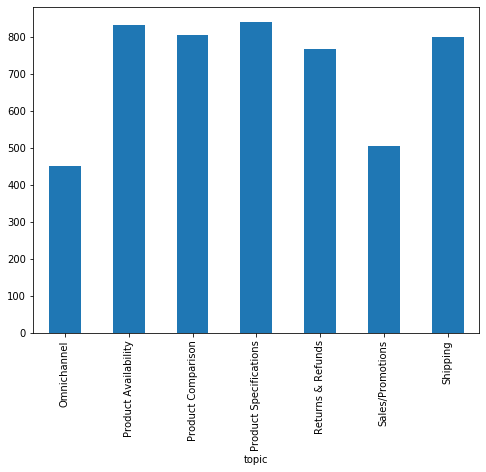

In [7]:
fig = plt.figure(figsize=(8,6))
df.groupby('topic').question.count().plot.bar(ylim=0)
plt.show()

We see that the number of questions per topic is imbalanced.Costumer questions are less for the topics Sales/Promotions and OmniChannel.

In [8]:
df['topic_id'] = df['topic'].factorize()[0]
df[['topic','topic_id']].drop_duplicates()

,topic,topic_id
0,Sales/Promotions,0
1,Shipping,1
34,Product Availability,2
36,Product Specifications,3
88,Omnichannel,4
143,Product Comparison,5
199,Returns & Refunds,6


##### Text Pre-Processing

In [9]:
from nltk.tokenize import regexp_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import wordninja
import re
lemmatizer = WordNetLemmatizer()
clean_text = []
for t in df['question']:
    for char in '!#$%&@?,.:;+-*/=<>"\'()[\\]X{|}~\n\t':
        question_text = str(t).replace(char, ' ')
    #Regular expressions to remove numbers from the review
    question_text = re.sub(r'\d+','',question_text)
    word_list = wordninja.split(question_text)# Word ninja  for splitting the words in a sentence.
    #Removing all the stop words and the words with length less than 1
    words = [w for w in word_list if len(w)>1 and w not in stopwords.words('english')]
    #Performing Word Lemmatization
    words = [lemmatizer.lemmatize(w) for w in words]
    clean_text.append(' '.join(words))

df['question'] = clean_text
df.head()

,question,topic,topic_id
0,Hi If sign email list select get email exclusi...,Sales/Promotions,0
1,I'm going country week travel I'm going gettin...,Shipping,1
2,wondering able overnight jacket Item Trenton NJ,Shipping,1
3,The Swing line electronic stapler look really ...,Shipping,1
4,think cosmetic bag would work great However kn...,Shipping,1


Splitting data into train and validation data :-

In [25]:
X_train, X_valid, Y_train, Y_valid = train_test_split(df['question'], df['topic'], random_state = 42)
encoder = LabelEncoder()
Y_train = encoder.fit_transform(Y_train)
Y_valid = encoder.fit_transform(Y_valid)
print(X_train.shape)
print(X_valid.shape)
print(Y_train.shape)
print(Y_valid.shape)

(3750,)
(1250,)
(3750,)
(1250,)


#### Word Vectorization

I preferred TFIDF vector over Count Vector for my model input since the model trained from count vector will be baised more
towards categories with most frequent words ignoring the rare words.

In [26]:
# Word level tf-idf
tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=5000)
tfidf_vect.fit(df['question'])
xtrain_tfidf = tfidf_vect.transform(X_train)
xvalid_tfidf = tfidf_vect.transform(X_valid)

In [28]:
def model(classifier, train_features, valid_features):
    classifier.fit(train_features, Y_train)  
    predict_y = classifier.predict(valid_features)
    accuracy = accuracy_score(Y_valid, predict_y)
    print('Accuracy: {:.3f}\n'.format(accuracy))
    print('Confusion Matrix')
    index = ['Sales/Promotions','Shipping','Product Availability','Product Specifications','Omnichannel','Product Comparison','Returns & Refunds']  
    columns = ['Sales/Promotions','Shipping','Product Availability','Product Specifications','Omnichannel','Product Comparison','Returns & Refunds']
    cm = metrics.confusion_matrix(Y_valid, predict_y)
    %matplotlib inline
    fig = plt.subplots(figsize=(10,5))
    sns.set(font_scale=1.4)#for label size
    cm_df = pd.DataFrame(cm,columns,index)
    sns.heatmap(cm_df,annot=True,annot_kws={"size": 14},fmt="d")# font size
    b, t = plt.ylim() # discover the values for bottom and top
    b += 0.5 # Add 0.5 to the bottom
    t -= 0.5 # Subtract 0.5 from the top
    plt.ylim(b, t) # update the ylim(bottom, top) values
    plt.show() # ta-da!
#     cm_df = pd.DataFrame(cm,columns,index)
#     fig, ax = plt.subplots(figsize=(10,5))
#     ax = sns.heatmap(cm_df,annot=True,annot_kws={"size": 16})# font size
    print(classification_report(Y_valid, predict_y))
    plt.show()
    return

### Model 1 :- Naive Bayes

Accuracy: 0.942

Confusion Matrix


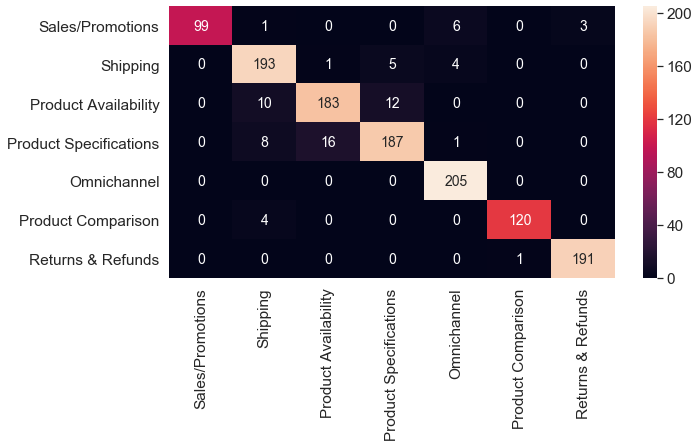

              precision    recall  f1-score   support

           0       1.00      0.91      0.95       109
           1       0.89      0.95      0.92       203
           2       0.92      0.89      0.90       205
           3       0.92      0.88      0.90       212
           4       0.95      1.00      0.97       205
           5       0.99      0.97      0.98       124
           6       0.98      0.99      0.99       192

    accuracy                           0.94      1250
   macro avg       0.95      0.94      0.95      1250
weighted avg       0.94      0.94      0.94      1250



In [29]:
model(MultinomialNB(), xtrain_tfidf,xvalid_tfidf)

### Ensemble Model :-Random Forest

C:\Users\krish\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Accuracy: 0.958

Confusion Matrix


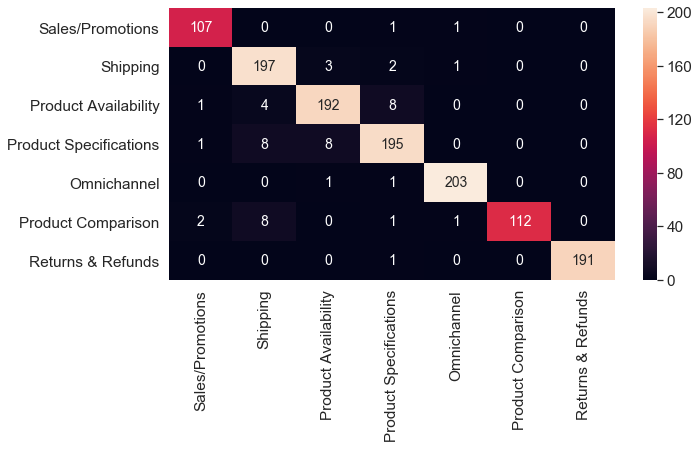

              precision    recall  f1-score   support

           0       0.96      0.98      0.97       109
           1       0.91      0.97      0.94       203
           2       0.94      0.94      0.94       205
           3       0.93      0.92      0.93       212
           4       0.99      0.99      0.99       205
           5       1.00      0.90      0.95       124
           6       1.00      0.99      1.00       192

    accuracy                           0.96      1250
   macro avg       0.96      0.96      0.96      1250
weighted avg       0.96      0.96      0.96      1250



In [30]:
model(RandomForestClassifier(), xtrain_tfidf, xvalid_tfidf)

The third model I used in this assignment is ensemble model which is created using SVM and KNN..This is based on the assumption that SVM-kNN can overcome theshortcomings of SVM and k-NN and improve the
performance of multi-class text classification. SVM is first used to identify category borders, then k-NN classifies documents among borders.

### Ensemble Model using Voting Classifier

Accuracy: 0.926

Confusion Matrix


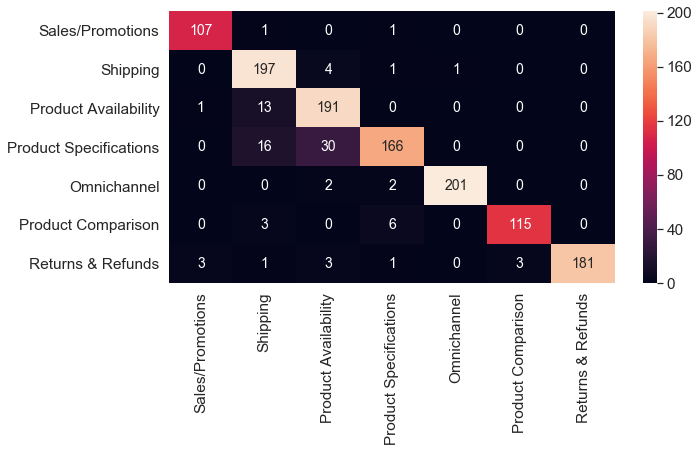

              precision    recall  f1-score   support

           0       0.96      0.98      0.97       109
           1       0.85      0.97      0.91       203
           2       0.83      0.93      0.88       205
           3       0.94      0.78      0.85       212
           4       1.00      0.98      0.99       205
           5       0.97      0.93      0.95       124
           6       1.00      0.94      0.97       192

    accuracy                           0.93      1250
   macro avg       0.94      0.93      0.93      1250
weighted avg       0.93      0.93      0.93      1250



In [31]:
clf_svm=SVC(gamma='scale')
clf_knn=KNeighborsClassifier()
voting_clf = VotingClassifier(estimators=[('svm',clf_svm), ('knn',clf_knn)],voting='hard')
model(voting_clf, xtrain_tfidf, xvalid_tfidf)

From the given list of categories I arranged all the categories according to their importance in any business:-

1)Shipping

2)Returns & Refunds

3)Sales/Promotions

4)Product Comparison

5)Product Availability

6)Product Specifications

7)Omni Channel


My main concern as a business user would be questions from the top categories should not be redirected to other categories.For example if questions from the customer regarding  "product shipping" if redirected to any of the remaining categories,there is a chance that customer getting negative opinion about the company even there might be potential loss of that costumer.In my perspective there will be minimal loss if the questions from categories with least priority redirected to the top ones.Hence in this scenario I will try to refine my model in such a way that my false negatives are less and recall rate should be high.

#### Model Evaluation

Average Recall Score for the various models are identified as <span style="color:red">0.94</span> for Naive Bayes Classifier,<span style="color:red">0.96</span> for Random Forest Classifier,
<span style="color:red">0.93</span> for ensemble model created using SVM and KNN.I verified my recall score by calculating the number of False negatives from confusion matrix.I believe that Random Forest Classifier would fit well for my  business problem since I am achieving higher overall recall rate.Further I will check if the model recall rate can be increased tuning any hyper parameters.

### Hyper Parameter Tuning-Random Forest Classifier

Fitting 5 folds for each of 144 candidates, totalling 720 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  8.8min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 23.0min
[Parallel(n_jobs=-1)]: Done 720 out of 720 | elapsed: 50.4min finished


Accuracy: 0.974

Confusion Matrix


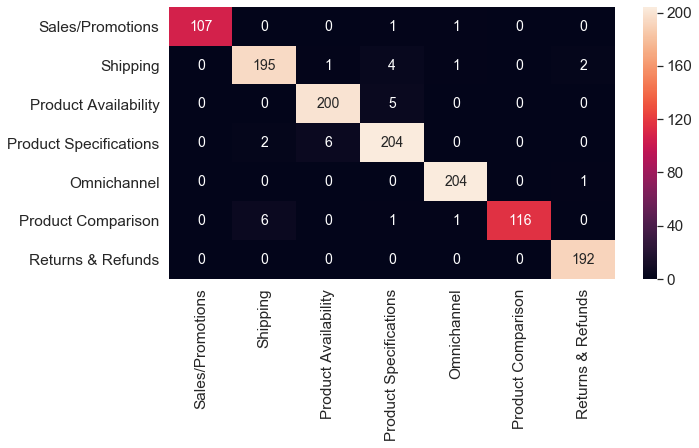

              precision    recall  f1-score   support

           0       1.00      0.98      0.99       109
           1       0.96      0.96      0.96       203
           2       0.97      0.98      0.97       205
           3       0.95      0.96      0.96       212
           4       0.99      1.00      0.99       205
           5       1.00      0.94      0.97       124
           6       0.98      1.00      0.99       192

    accuracy                           0.97      1250
   macro avg       0.98      0.97      0.98      1250
weighted avg       0.97      0.97      0.97      1250



In [34]:
#Hyperparameter tuning
#Gridsearch with 5-fold cross validation

#RF
bootstrap = [True, False]
max_depth = [10, 50, 100, None]
max_features = ['auto', 'sqrt']
min_samples_leaf = [1, 2, 4]
min_samples_split = [2, 5, 10]
n_estimators = [800, 1400, 2000]
random_state = [3]

clf = RandomForestClassifier()

params = dict(bootstrap = bootstrap,
              max_depth = max_depth,
              max_features = max_features,
              min_samples_leaf = min_samples_leaf,
              n_estimators = n_estimators,
              random_state=random_state)

gridsearch = GridSearchCV(clf,
                          params, 
                          cv=5,
                          verbose=1, 
                          n_jobs=-1)

model(gridsearch, xtrain_tfidf, xvalid_tfidf)

Observation :- Average recall rate improved from 0.96 to 0.97 for Random Forest Classifier after tuning various hyper parameters